In [1]:
from IPython.core.display import HTML
display(HTML("<style>.container { width:95% !important; }</style>"))   

Author: Andrew Tarzia

Date Created: 26 Mar 2018

License:

# Notebook for calculating the relative zinc ion affinity for different models of carbohydrate chains

TODO:


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# replace matlab BVP solver with scipy
from scipy.integrate import solve_bvp
import scipy.special as sc
import expressions_sphere as exp_s
from scipy import constants

In [3]:
# constants
KB = constants.Boltzmann # boltzmann constant [J/K]
NA = constants.N_A # avogadros number [mol-1]
e = constants.elementary_charge # elementary charge [C]
E_0 = constants.epsilon_0 # Vacuum permittivity [F/m = C^2/(J.m)]
M_TO_NM = 1.0e9 # conversion from m to nm
M3_TO_L = 1.0e3 # conversion from m^3 to L
PI = constants.pi

## Set polymer variables

In [4]:
# Lc is approximate monomer length (length of Glucose unit)
Lc = 5 # angstrom
# DP is the number of monomers in carbohydrate chain
# or degree of polymerisation DP
# set such that MW is arround 3200 Da
DP = 60

## Determine pervaded volume

In [5]:
# from literature:
# - Carboxymethyl and native dextran behave as freely jointed chains
# - Kuhn length is approximately the same as the length of the glucose monomer
# calculate radius of gyration Rg using equation for Freely Jointed Chain
Rg_2 = (DP * Lc ** 2) / 6
Rg = np.sqrt(Rg_2)
print("radius of gyration =", round(Rg, 3), "angstrom")

# calculate the pervaded volume as the volume of a sphere with radius == Rg
Vg = (4/3) * PI * (Rg ** 3)
print("pervaded volume =", round(Vg, 3), "angstrom^3")

radius of gyration = 15.811 angstrom
pervaded volume = 16557.647 angstrom^3


##  Set Solution variables

In [6]:
# set temp
T = 298 # [K]
# thermal voltage [V]
Vt = KB*T/(e)
# set relative permittivity [unit less] -- water!
E_r = 78.46 
# set pH of solution
PH = 11
# salt concs (1 = Zn2+)
salt1_conc = 0.04  # mol/L 
salt2_conc = 0.08  # mol/L 
# bulk salt conc (total)
salt_conc = salt1_conc + salt2_conc  # mol/L 
# ion valencies
Z1 = 2  # zinc 2+
Z2 = -1  # co-ion

## Determine total polymer charge as a function of DS

In [7]:
func_colors = {"COO": 'firebrick', "NH2": 'royalblue'}  # set plot colours for the different functionalities

# set functionalisation density as degree of substitution:
# DS = avg number of substituted OH for R per glucose (max at 3, for 3 OH per glucose)
# vary the degree of substitution
DS = np.linspace(0, 0.5, 20)
# the total number of charge centres on the chain based on the DS and DP
func_count = DS * DP

# set charge and pka of functionalisations
func_charges = {"COO": -1, "NH2": +1}
func_pkas = {"COO": 4, "NH2": 12}  #### UPDATE THESE 

# calculate cylinder charge of each functionalisation based on pH 
func_total_charges = {}
for func in func_charges.keys():
    pka = func_pkas[func]
    charge = func_charges[func]
    partial_charge = exp_s.calculate_func_charge(charge, PH, pka)
    func_total_charges[func] = func_count * partial_charge


In [8]:
fig, ax = plt.subplots(figsize=(8, 6))
for func in func_charges.keys():
    ax.scatter(DS, func_total_charges[func], label=func, c=func_colors[func])

ax.set_xlabel("DS", fontsize=18)
ax.set_ylabel("cylinder charge [e]", fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(fancybox=True, ncol=2, # bbox_to_anchor=(1.5, -0.3),
           fontsize=18)

ax.axvline(x=0.125, c='k', lw=2)
ax.set_ylim(-27, 27)
plt.show()

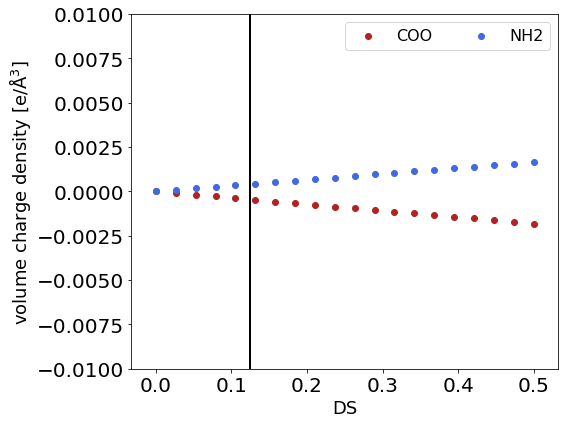

In [9]:
fig, ax1 = plt.subplots(figsize=(8, 6))
ax1.tick_params(axis='both', which='major', labelsize=20)
for func in func_charges.keys():
    # calculate volume charge density as total charge / Volume
    Vg_q = func_total_charges[func] / Vg  # e/angstrom^3
    ax1.scatter(DS, Vg_q, c=func_colors[func], label=func)
    
# ax1.set_title('volume charge density', fontsize=18)
ax1.set_xlabel("DS", fontsize=18)
ax1.set_ylabel('volume charge density [e/$\mathrm{\AA}^3$]', fontsize=18)
ax1.axvline(x=0.125, c='k', lw=2)
ax1.set_ylim(-0.01, 0.01)

ax1.legend(fancybox=True, ncol=2, # bbox_to_anchor=(1.5, -0.3),
           fontsize=16)
fig.tight_layout()
fig.savefig('../../documents/images/cylinder_model_spherical_vcd.pdf', dpi=720, bbox_inches='tight')

In [10]:
resolution = 0.1  # angstrom
max_r = 100  # angstrom
radius_to_incl = 0.74  # zinc ion radius in angstrom
# number of nodes to include radius on either side
nodes_incl = int(radius_to_incl / resolution)

In [11]:
# radial positions from centre of cylinder in angstrom
r_in = np.linspace(0, max_r, int(max_r / resolution))
# split into regions
r_in_1 = r_in[r_in <= Rg]
r_in_2 = r_in[r_in > Rg]

In [12]:
def calculate_kappasq(e, I, e0, eR, KB, T, PI):
    """
    Calculate kappa^2 (== debye length ^ (-1/2)) in m^-2 (SI units)
    
    """
    top = 2 * (e ** 2) * I 
    bottom = e0 * eR * KB * T
    
    kappasq = top / bottom
    
    return kappasq

In [13]:
print("-------------------------------")
# calculate ionic strength
I = 0.5 * ((salt1_conc * Z1 * Z1) + (salt2_conc * Z2 * Z2))  # mol/L
print('I =', I, 'mol/L')
# in molec per m3
I_m = NA * I * M3_TO_L  # molecules / m3
print('I =', I_m, 'm^-3')
print("-------------------------------")
# calculate kappasq
# in angstrom^-2
kappasq = calculate_kappasq(e, I_m, E_0, E_r, KB, T, PI)
print('kappa^2 =', round(kappasq, 3), 'm^-2')
print('kappa =', round(np.sqrt(kappasq * (10 ** -20)), 3), 'angstrom^-1')
print('debye length =', round(1/np.sqrt(kappasq * (10 ** -20)), 3), 'angstrom')
print("-------------------------------")

-------------------------------
I = 0.12 mol/L
I = 7.2265690284e+25 m^-3
-------------------------------
kappa^2 = 1.2980352954683128e+18 m^-2
kappa = 0.114 angstrom^-1
debye length = 8.777 angstrom
-------------------------------


In [14]:
def calculate_conc(pot, bulk, val, e, KB, T):
    """
    Calculate the concentration of ion with bulk conc bulk and valency val at a position with potential pot in V using the Boltzman equation
    """
    B = (-val * e * pot) / (KB * T)
    conc = bulk * np.exp(B)
    return conc

In [15]:
fig = plt.figure(figsize=(18, 4))
ax1 = plt.subplot(131)
ax1.tick_params(axis='both', which='major', labelsize=20)
# label
ax1.text(0.01, 0.9, '(a)',
         verticalalignment='bottom', horizontalalignment='left',
         transform=ax1.transAxes,
         fontsize=18)

ax2 = plt.subplot(132)
ax2.tick_params(axis='both', which='major', labelsize=20)
# label
ax2.text(0.01, 0.9, '(b)',
         verticalalignment='bottom', horizontalalignment='left',
         transform=ax2.transAxes,
         fontsize=18)

ax3 = plt.subplot(133)
ax3.tick_params(axis='both', which='major', labelsize=20)
# label
ax3.text(0.01, 0.9, '(c)',
         verticalalignment='bottom', horizontalalignment='left',
         transform=ax3.transAxes,
         fontsize=18)


func_surface_concentration = {}
for func in func_charges.keys():
    print("===================", func, "==================")
    for i, ds in enumerate(DS):
        # calculate volume charge density as total charge / Volume
        Vg_q = func_total_charges[func][i] / Vg  # e/angstrom^3
        Vg_q_si = Vg_q * e * (10 ** 30) # C/m^3
        kappa_si = np.sqrt(kappasq) # m^-1
        Rg_si = Rg * (10 ** -10) # m
        r_in_1_si = r_in_1 * (10 ** -10) # m
        r_in_2_si = r_in_2 * (10 ** -10) # m
        kappa_a_si = kappa_si * Rg_si   # kappa times Rg in SI units
        
        front = Vg_q_si / (E_0 * E_r * (kappa_si ** 2))
        
        inner_ = front * (1 - ((1 + (1/kappa_a_si)) * Rg_si * np.exp(-kappa_a_si) * (1/r_in_1_si) * np.sinh(kappa_si * r_in_1_si)))
        outer_ = front * (np.cosh(kappa_a_si) - (1/kappa_a_si) * np.sinh(kappa_a_si) ) * Rg_si * np.exp(-kappa_si * r_in_2_si) * (1/r_in_2_si)
        ax1.plot(r_in_1, inner_ * 1000, c=func_colors[func])
        ax1.plot(r_in_2, outer_ * 1000, c=func_colors[func])
        
        # get potential at surface
        inner_surf = np.average(inner_[-nodes_incl:])
        outer_surf = np.average(outer_[:nodes_incl+1])
        ax2.scatter(ds, np.average([inner_surf, outer_surf]) * 1000, c=func_colors[func])
        
        # get zinc ion enhancement at surface from potential
        zinc_conc = calculate_conc(np.average([inner_surf, outer_surf]), salt1_conc, Z1, e, KB, T)
        ax3.scatter(ds, zinc_conc/salt1_conc, c=func_colors[func])
        
        
# ax2.set_title(r'surface potential', fontsize=18)
# ax2.set_xlabel("distance from cylinder surface [$\mathrm{\AA}$]", fontsize=18)
ax1.set_ylabel("$\psi(r)$ [mV]", fontsize=18)
ax1.set_xlabel("$r$ [$\mathrm{\AA}$]", fontsize=18)
ax1.axvspan(r_in_1[-nodes_incl], r_in_2[nodes_incl+1], facecolor='k', lw=2, alpha=0.4)
ax1.set_xlim(0, 50)
ax1.set_ylim(-350, 350)
# legend
for func in func_charges.keys():
    ax1.scatter(-1000, -1000, c=func_colors[func], label=func)

ax1.legend(fancybox=True, ncol=1, loc=4, fontsize=16)


ax2.set_ylabel("$<\psi(a)>$ [mV]", fontsize=18)
ax2.set_xlabel("DS", fontsize=18)
#ax2.set_xlim(0, 30)
#ax2.set_ylim(-200, 200)
ax2.axvline(x=0.125, c='k', lw=2)

ax3.set_ylabel("log Zn$^{2+}$ enhancement", fontsize=18)
ax3.set_xlabel("DS", fontsize=18)
#ax2.set_xlim(0, 30)
ax3.set_ylim(0, 10000)
ax3.axvline(x=0.125, c='k', lw=2)
ax3.set_yscale("symlog", nonposy='clip')


fig.tight_layout()
fig.savefig('../../documents/images/cylinder_model_spherical_analytical.pdf', dpi=720, bbox_inches='tight')

=================== COO ==================
=================== NH2 ==================


/home/atarzia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in true_divide
/home/atarzia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in multiply
